In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

np.random.seed(42)

# The perceptron

The perceptron is a very simple neural network that performs binary classification, e.g. tries to determine whether ${\bf F}_i$ is a picture of a cat ($y_i = +1$) or a dog ($y_i = -1$). In order to train the classifier, i.e. to determine its weights ${\bf x} \in \mathbb{R}^N$, one has to solve 

$${\bf y} = \operatorname{sgn} (F {\bf x})$$.

Let's put this problem in a probabilistic framework. We introduce a Gaussian noise inside the $\operatorname{sgn}$, so as to have a probit likelihood; moreover we will assume that the weights are binary, ${\bf x} \in \{+1, -1\}^N$. The full model reads

$$\left\{
\begin{aligned}
    &x_i \sim \frac12 \, \delta(x_i - 1) + \frac12 \, \delta (x_i + 1), \\
    &y_\mu \sim \frac{1}{2} \operatorname{erfc} \big( \frac{1}{\sqrt{2 \sigma^2}} {\bf F}_\mu \cdot {\bf x} \big).
\end{aligned}
\right.
$$

We start as usual by sampling from $P({\bf x}, {\bf y} | F)$.

In [2]:
def sample_instance(size_x, rows_to_columns, var_noise):
    """Samples F from P(F) and {x, y} from P(x, y | F)"""
    
    # Some pre-processing
    size_y = int(np.ceil(rows_to_columns * size_x))
    
    # Sample x from P_0(x)
    x0 = np.random.choice([+1, -1], size_x)
    
    # Generate F and y = sgn(Fx + noise)
    F = np.random.randn(size_y, size_x) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_y)
    y = np.sign(F.dot(x0) + noise)

    return x0, F, y

In [3]:
x, F, y = sample_instance(2000, 1.6, 1e-10)
print(x)
print(y)

[ 1 -1  1 ...  1  1  1]
[-1. -1. -1. ... -1. -1. -1.]


## Implementing GAMP: generalized approximate message-passing

One can adapt AMP to arbitrary likelihoods $P(y | z)$. The important quantity to compute is

$$
Z_z (y, \omega, V) = \int dz \, P(y | z) \, \mathcal{N} (z; \omega, V)
$$

from which $g (y, \omega, V) = \partial_\omega \log Z_z$ can be obtained. The iteration becomes

$$
\begin{aligned}
&\omega_\mu^t = \sum_i F_{\mu i} a_i^t + V_\mu^t g(y_\mu, \omega_\mu^{t-1}, V_\mu^{t-1}), &\qquad
&V_\mu^t = \sum_i F_{\mu i}^2 c_i^t, \\
&B_i^t = A_i^t a_i^t + \sum_\mu F_{\mu i} g(y_\mu, \omega_\mu^t, V_\mu^t), &\qquad
&A_i^t = \sum_\mu F_{\mu i}^2 \partial_\omega g(y_\mu, \omega_\mu^t, V_\mu^t), \\
&a_i^{t + 1} = f_a (A_i^t, B_i^t), &\qquad
&c_i^{t + 1} = f_c (A_i^t, B_i^t).
\end{aligned}
$$

Note that for Gaussian likelihoods, $P (y | z) = \mathcal{N} (y; z, \sigma^2)$, one gets $g(y, \omega, V) = \frac{y - \omega}{V + \sigma^2}$, thus recovering the same expression as before.

In [4]:
def iterate_gamp(F, y, var_noise,
                 x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterates GAMP to solve y = sign(Fx), w/ x Rademacher"""
    
    # Some pre-processing
    size_y, size_x = F.shape
    sqrF = F * F
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    a = np.zeros(size_x)
    c = np.ones(size_x)
    
    v = np.ones(size_y)
    w = np.copy(y)
    g = np.zeros(size_y)
    dg = np.ones(size_y)
    
    a_old = np.zeros(size_x)
    
    mses = np.zeros(max_iter)
    for t in range(max_iter):
        # Iterate w and v, and compute g and g'
        g_old = np.copy(g)
        v = sqrF.dot(c)
        w = F.dot(a) - v * g_old
        g, dg = channel(y, w, v, var_noise)
        
        # Iterate A and B, and compute a and c
        a_old = np.copy(a)
        A = -sqrF.T.dot(dg)
        B = F.T.dot(g) + A * a
        a, c = prior(A, B)
        
        # Compute metrics
        diff = np.mean(np.abs(a - a_old))
        mses[t] = np.mean((a - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mses[t]))
        
        # Check for convergence
        if diff < tol or mses[t] == 0:
            break
            
    return mses

We now need to implement the functions $f$ and $g$. Essentially this means computing $\log Z_z (y, \omega, V) = \int dz \, P(y | z) \, \mathcal{N} (z; \omega, V)$ and its two first derivatives wrt $\omega$, and $\log Z_X (A, B) = \int dx \, P_0 (x) \, e^{-\frac12 A x^2 + Bx}$ and its two first derivatives wrt $B$.

We do that below for a Rademacher prior and a probit channel.

In [5]:
from scipy.special import erfcx

def prior(A, B):
    """Compute f and f' for Rademacher prior"""
    
    a = np.tanh(B)
    c = 1 - a ** 2
    return a, c

def channel(y, w, v, var_noise):
    """Compute g and g' for probit channel"""
    
    phi = -y * w / np.sqrt(2 * (v + var_noise))
    g = 2 * y / (np.sqrt(2 * np.pi * (v + var_noise)) * erfcx(phi))
    dg = -g * (w / (v + var_noise) + g)
    
    return g, dg

In [6]:
mses_gamp = iterate_gamp(F, y, var_noise=1e-10, x0=x);

t = 0, diff = 0.689799; mse = 0.428197
t = 1, diff = 0.241056; mse = 0.279662
t = 2, diff = 0.127886; mse = 0.212067
t = 3, diff = 0.0913546; mse = 0.165681
t = 4, diff = 0.0688579; mse = 0.130487
t = 5, diff = 0.0605754; mse = 0.103494
t = 6, diff = 0.0498199; mse = 0.0818637
t = 7, diff = 0.0414233; mse = 0.0613063
t = 8, diff = 0.0365946; mse = 0.0408108
t = 9, diff = 0.02819; mse = 0.0216691
t = 10, diff = 0.0211583; mse = 0.00749102
t = 11, diff = 0.00924465; mse = 1.8211e-05
t = 12, diff = 0.000203339; mse = 0


Cool, it seems to work! Moreover it gives us a small error, again a consequence of the parameters we chose. You can try to reduce the number of samples (i.e. use a smaller `rows_to_columns`) to see what happens.

## State evolution

As before, we can look at the state evolution associated to the algorithm above to see what should be the expected performance as a function of the amount of samples.

In [7]:
from scipy.integrate import quad
from scipy.special import erfc

def iterate_se(rows_to_columns, var_noise, v0=1, max_iter=250, tol=1e-11, verbose=1):
    """Iterates state evolution associated to AMP implementation above"""
    
    # Define function to be integrated at each step
    f = lambda a: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            (1 - np.tanh(a + np.sqrt(a) * z) ** 2)
   
    def int_g(v):
        var = .5 * (1 - v) / (v + var_noise)
        g0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise)[1]
        if var == 0:
            return g0(0)
        else:
            g = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * g0(z)
            return quad(g, -10, 10)[0]
    
    v = np.zeros(max_iter)
    v[0] = v0
    
    for t in range(max_iter - 1):
        a = -rows_to_columns * int_g(v[t])
        v[t + 1] = quad(f(a), -10, 10)[0]
        
        diff = np.abs(v[t + 1] - v[t])
        if verbose:
            print("t = %d, diff = %g; v = %g" % (t, diff, v[t + 1]))
            
        if diff < tol:
            break

    return v[:t + 1]

In [8]:
mses_se = iterate_se(rows_to_columns=1.5, var_noise=1e-10, max_iter=500);

t = 0, diff = 0.535854; v = 0.464146
t = 1, diff = 0.145087; v = 0.319058
t = 2, diff = 0.0638839; v = 0.255174
t = 3, diff = 0.0354016; v = 0.219773
t = 4, diff = 0.0224003; v = 0.197373
t = 5, diff = 0.0154477; v = 0.181925
t = 6, diff = 0.0113159; v = 0.170609
t = 7, diff = 0.00866843; v = 0.161941
t = 8, diff = 0.00687379; v = 0.155067
t = 9, diff = 0.00560298; v = 0.149464
t = 10, diff = 0.00467128; v = 0.144793
t = 11, diff = 0.00396866; v = 0.140824
t = 12, diff = 0.0034263; v = 0.137398
t = 13, diff = 0.00299942; v = 0.134398
t = 14, diff = 0.00265786; v = 0.13174
t = 15, diff = 0.00238074; v = 0.12936
t = 16, diff = 0.00215323; v = 0.127206
t = 17, diff = 0.00196457; v = 0.125242
t = 18, diff = 0.00180679; v = 0.123435
t = 19, diff = 0.00167391; v = 0.121761
t = 20, diff = 0.00156138; v = 0.1202
t = 21, diff = 0.00146566; v = 0.118734
t = 22, diff = 0.00138402; v = 0.11735
t = 23, diff = 0.00131426; v = 0.116036
t = 24, diff = 0.00125468; v = 0.114781
t = 25, diff = 0.0012039;

We can then ask ourselves: how much samples are needed in order to achieve zero error? Let's do a simple binary search to see.

In [9]:
def find_spinodal(tol=1e-4, threshold=1e-5, verbose=1):
    """Determines algorithmic transition by performing binary search"""
    
    # Returns True if solution has been found
    f = lambda x: (iterate_se(x, 1e-10, max_iter=1000, verbose=0)[-1] < threshold)
    
    # Perform binary search
    alpha_l, alpha_r = 0, 2
    f_l, f_r = f(alpha_l), f(alpha_r)
    while alpha_r - alpha_l > tol:
        alpha_m = .5 * (alpha_l + alpha_r)
        f_m = f(alpha_m)
        if verbose:
            print("alpha = %g, found solution = %s" % (alpha_m, f_m))
        
        if f_m:
            alpha_r = alpha_m
        else:
            alpha_l = alpha_m
            
    return .5 * (alpha_l + alpha_r)

find_spinodal()

alpha = 1, found solution = False
alpha = 1.5, found solution = True
alpha = 1.25, found solution = False
alpha = 1.375, found solution = False
alpha = 1.4375, found solution = False
alpha = 1.46875, found solution = False
alpha = 1.48438, found solution = False
alpha = 1.49219, found solution = False
alpha = 1.49609, found solution = True
alpha = 1.49414, found solution = True
alpha = 1.49316, found solution = True
alpha = 1.49268, found solution = True
alpha = 1.49243, found solution = False
alpha = 1.49255, found solution = False
alpha = 1.49261, found solution = False


1.492645263671875

$\alpha_s = 1.493$ is the same number found by [4].

## A closer look at the 1st order phase transition

The fact that the error jumps from a finite value to 0 at $\alpha_s = 1.493$ is indicative of a 1st order phase transition. This usually means that, already for smaller values of $\alpha$, the planted solution could have been found by an exhaustive search, but AMP in stuck in local minima (or metastable states).

Let's look at the free energy landscape to try to understand this better. We first implement a function to compute the replica free energy as a function of the error (see e.g. [2]). The replica free energy can be seen as an average over all possible instances of the Bethe free energy (the function AMP is minimizing), and thus gives us some intuition on AMP's behavior.

In [10]:
from scipy.integrate import quad

def phi(v, rows_to_columns, var_noise=1e-10):
    """Compute replica free energy for Ising perceptron"""
    
    # Compute A(V) using SE iteration
    dg0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise)[1]
    var = .5 * (1 - v) / (v + var_noise)
    if var == 0:
        a = -rows_to_columns * dg0(0)
    else:
        dg = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * dg0(z)
        a = -rows_to_columns * quad(dg, -10, 10)[0]    
    
    # Compute <log Z_z>
    lnzz0 = lambda z: erfc(z) * np.log(.5 * erfc(z))
    if var == 0:
        avg_lnzz = lnzz0(0)
    else:
        lnzz = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * lnzz0(z)
        avg_lnzz = quad(lnzz, -10, 10)[0]

    # Compute <log Z_x>
    lnzx = lambda z: np.exp(-.5 * z ** 2) / np.sqrt(2 * np.pi) * \
            (np.log(np.cosh(a + np.sqrt(a) * z)) if np.abs(a + np.sqrt(a) * z) < 100 else \
                np.abs(a + np.sqrt(a) * z) - np.log(2))
    avg_lnzx = -.5 * a + quad(lnzx, -10, 10)[0]
    
    return .5 * a * (1 - v) - rows_to_columns * avg_lnzz - avg_lnzx

We now compute and plot the free energy as function of the error, for multiple values of $\alpha$ (samples-to-features ratio)

/home/ndrmnl/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


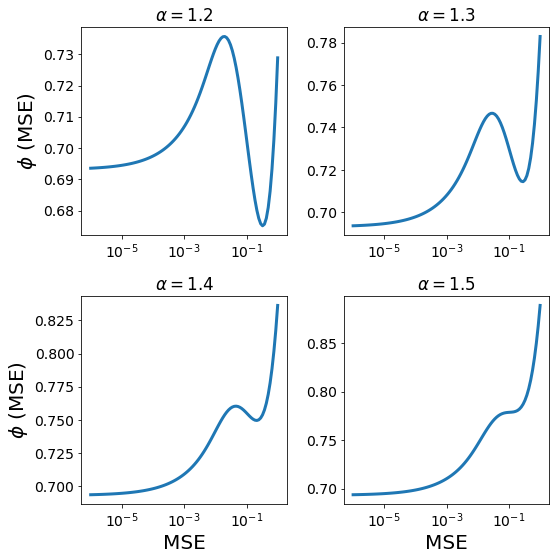

In [11]:
# Compute and plot free energy as a function of the MSE, i.e. $\phi (V)$, for many different $\alpha$
alphas = [1.2, 1.3, 1.4, 1.5]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, alpha in enumerate(alphas):
    vs = np.logspace(-6, 0, 100)
    phis = [phi(v, alpha) for v in vs]
    axs[i // 2, i % 2].semilogx(vs, phis, lw = 3)
    
    # Add labels
    axs[i // 2, i % 2].set_title(r"$\alpha = %.1f$" % (alpha))
    if i // 2 == 1:
        axs[i // 2, i % 2].set_xlabel("MSE", fontsize=20)
    if i % 2 == 0:
        axs[i // 2, i % 2].set_ylabel(r"$\phi$ (MSE)", fontsize=20)
fig.set_tight_layout(True)

It is quite interesting to try to understand the phase transition from the free energy landscape point of view.

First let's see what happens at the point where zero error starts to be found (bottom right): the free energy has a single minimum at 0. In the previous 2 plots, for slightly smaller $\alpha$, it had two minima: one at zero and another at large error; however, the zero error minimum was already global, meaning it could have been found by an exhaustive search. Before that the zero error minimum was local, and it wasn't distinguishable from the other minima -- in other words, one could find other minima that better fit our data.

Finally, let's do a MSE vs. $\alpha$ plot to connect this to what we have seen in class.

In [12]:
from scipy.optimize import brent

alphas = np.arange(0.01, 1.6, 0.01)
mse_random = np.zeros(len(alphas))
mse_inform = np.zeros(len(alphas))
mse_unstab = np.zeros(len(alphas))

# Loop through values of alpha
for i, alpha in enumerate(alphas):
    # Compute stable fixed points by starting from random/informed initializations
    mse_random[i] = iterate_se(alpha, var_noise=1e-10, v0=1, max_iter=1000, verbose=0)[-1]
    mse_inform[i] = iterate_se(alpha, var_noise=1e-10, v0=1e-9, max_iter=1000, verbose=0)[-1]
    
    # Compute unstable fixed point by performing gradient ascent on free energy
    if mse_random[i] > 0:
        f = lambda x: -phi(x, alpha)
        mse_unstab[i] = brent(f, brack=(1e-10, mse_inform[i]))
    
    print("alpha = %.2f, fps = %g/%g/%g" % (alpha, mse_random[i], mse_unstab[i], mse_inform[i]))

alpha = 0.01, fps = 0.993648/5.62689e-08/0
alpha = 0.02, fps = 0.987325/2.79828e-07/0
alpha = 0.03, fps = 0.98103/7.24126e-07/0
alpha = 0.04, fps = 0.974761/1.4318e-06/0
alpha = 0.05, fps = 0.968519/2.44099e-06/0
alpha = 0.06, fps = 0.962302/3.78737e-06/0
alpha = 0.07, fps = 0.95611/5.50556e-06/0
alpha = 0.08, fps = 0.949942/7.62825e-06/0
alpha = 0.09, fps = 0.943797/1.01877e-05/0
alpha = 0.10, fps = 0.937676/1.32187e-05/0
alpha = 0.11, fps = 0.931576/1.67541e-05/0
alpha = 0.12, fps = 0.925499/2.08231e-05/0
alpha = 0.13, fps = 0.919443/2.54549e-05/0
alpha = 0.14, fps = 0.913407/3.06836e-05/0
alpha = 0.15, fps = 0.907392/3.65563e-05/0
alpha = 0.16, fps = 0.901397/4.30888e-05/0
alpha = 0.17, fps = 0.895421/5.03206e-05/0
alpha = 0.18, fps = 0.889464/5.82857e-05/0
alpha = 0.19, fps = 0.883526/6.70182e-05/0
alpha = 0.20, fps = 0.877606/7.65533e-05/0
alpha = 0.21, fps = 0.871703/8.69263e-05/0
alpha = 0.22, fps = 0.865819/9.81732e-05/0
alpha = 0.23, fps = 0.859951/0.000110331/0
alpha = 0.24, 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


alpha = 1.54, fps = 2.12545e-20/1.12578/0
alpha = 1.55, fps = 0/0/0
alpha = 1.56, fps = 0/0/0
alpha = 1.57, fps = 8.35005e-15/1.51088/0
alpha = 1.58, fps = 0/0/0
alpha = 1.59, fps = 0/0/0


Text(0,0.5,'MSE')

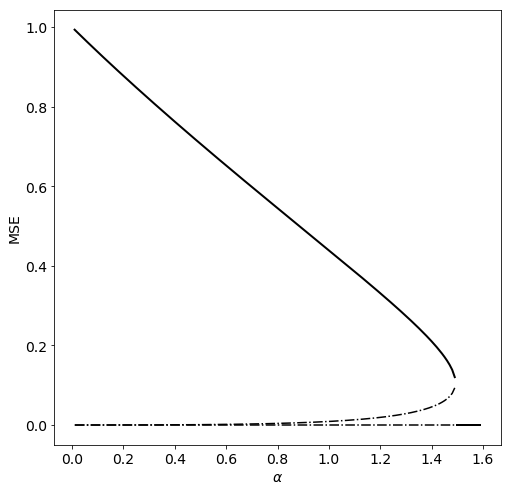

In [13]:
# Plot results
cond = (mse_random > 1e-9)
plt.plot(alphas[cond], mse_random[cond], "k-", lw=2)
plt.plot(alphas[~cond], mse_inform[~cond], "k-", lw=2)
plt.plot(alphas[cond], mse_inform[cond], "k-.")
plt.plot(alphas[cond], mse_unstab[cond], "k-.")

plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")

## References

1. Zdeborová, Lenka, and Florent Krzakala. "Statistical physics of inference: Thresholds and algorithms." Advances in Physics 65.5 (2016): 453-552.

2. Engel, Andreas. Statistical mechanics of learning. Cambridge University Press, 2001.

3. Gardner, Elizabeth. "The space of interactions in neural network models." Journal of physics A: Mathematical and general 21.1 (1988): 257.

4. Györgyi, Géza. "First-order transition to perfect generalization in a neural network with binary synapses." Physical Review A 41.12 (1990): 7097.

5. Seung, H. S., Haim Sompolinsky, and N. Tishby. "Statistical mechanics of learning from examples." Physical Review A 45.8 (1992): 6056.

6. Rangan, Sundeep. "Generalized approximate message passing for estimation with random linear mixing." Information Theory Proceedings (ISIT), 2011 IEEE International Symposium on. IEEE, 2011.